In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Dataset url
DATASET_URL = "https://gist.githubusercontent.com/duongttr/ff8728ebd7601e67c7d9eca1e86663ce/raw/02b90bb36befb7a7ca95747eaf21309511f796de/Food.csv"

# Watch how the dataset look like
df = pd.read_csv(DATASET_URL)
df.head(10)

# Required features for training model
features = ['start time', 'end time', 'Unnamed: 11', 'venue', 'container', 'describe how to make it',
            'viewer feeling of youtuber\'s style ']

data = df[features].dropna() # Firstly, drop all NaN value in dataset

# Remove all unknown values
data = data[data['start time'].str.contains('start') == False]
data = data[data['start time'].str.contains('Start') == False]
data = data[data['end time'].str.contains('x') == False]
data = data[data['end time'].str.contains('end') == False]
data = data[data['end time'].str.contains('End') == False]
data = data[data['end time'].str.contains('x') == False]

# Rename columns' names
data = data.rename(columns={'Unnamed: 11': 'ingre_count', 'describe how to make it': 'is_described', 
             "viewer feeling of youtuber\'s style ": 'feeling'})

# Convert feeling type
data['feeling'] = data['feeling'].astype(int).replace({0: 1})

# Replace unspecificed values
data['venue'] = data['venue'].replace({'boat restaurant': 'other', 'home': 'other'})
data['container']=data['container'].replace(
              {'hand': 'hands-on', 'no': 'hands-on', 'clay bot': 'pot', 'tray ': 'tray',
              'plastic glass': 'glass', 'Bag': 'bag', 'cup': 'glass'})

data=data[data['is_described'] != '3']
data['is_described']=data['is_described'].astype(int)

# Calculate duration
pattern = '(\d+).*?[;:].*?(\d+)'
def calculate_duration(row):
  import re
  pattern = '(\d+).*?[;:.].*?(\d+)'
  start_time = row[0]
  end_time = row[1]

  try:
    start_min, start_sd = list(map(int, re.findall(pattern, start_time)[0]))
    end_min, end_sd = list(map(int, re.findall(pattern, end_time)[0]))
  except:
    print(row)
    return 0

  return end_min * 60 + end_sd - (start_min *60 + start_sd)

data['duration'] = data.apply(calculate_duration, axis=1)
data = data[data['duration'] > 0]

data=data.drop(labels=['start time', 'end time'], axis=1)

data['venue']=data['venue'].replace({v: k for k, v in dict(enumerate(data['venue'].unique())).items()})
data['container']=data['container'].replace({v: k for k, v in dict(enumerate(data['container'].unique())).items()})

OH_venue = pd.get_dummies(data['venue'], 'venue')
OH_container = pd.get_dummies(data['container'], 'container')

data=data.drop(labels=['venue', 'container'], axis=1)
data=data.join([OH_venue, OH_container])

y = data['feeling']
X = data.drop('feeling', axis=1)
X['duration'] = np.log(X['duration'] + 1e-8)
X['ingre_count'] = np.log(X['ingre_count'] + 0.05)
# Make feature more-likely normal distribution
# X[['duration', 'ingre_count']] = MinMaxScaler((-1, 1)).fit_transform(X[['duration', 'ingre_count']])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=99)

# KMeans

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

clustering = KMeans(n_clusters=5, random_state=99)

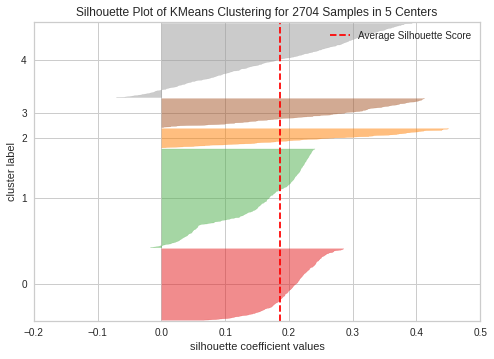

In [ ]:
si_vis = SilhouetteVisualizer(clustering).fit(X_train)
si_vis.show();

In [ ]:
print('Silhouette Score:',si_vis.silhouette_score_)

Silhouette Score: 0.18674018124940403


In [ ]:
y_train_pred = si_vis.predict(X_train) 
y_test_pred = si_vis.predict(X_test)

In [ ]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

from scipy.special import comb
def rand_index(actual, pred):
    tp_plus_fp = comb(np.bincount(actual), 2).sum()
    tp_plus_fn = comb(np.bincount(pred), 2).sum()
    A = np.c_[(actual, pred)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [ ]:
from sklearn.metrics import silhouette_score
print('Train rand index score:',rand_index(y_train, y_train_pred))
print('Test rand index score:', rand_index(y_test, y_test_pred))

Train rand index score: 0.6110655046879755
Test rand index score: 0.6120226109939436


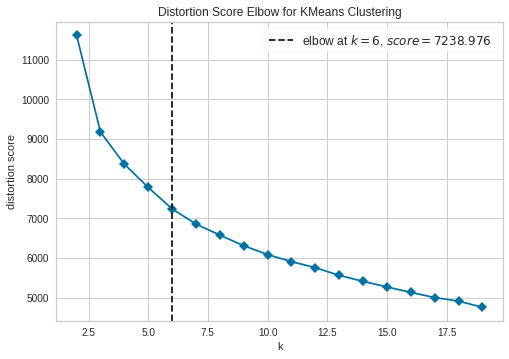

In [ ]:
# Instantiate the clustering model and visualizer
kelbow_vis = KElbowVisualizer(KMeans(random_state=99), k=(2,20), metric='distortion', timings=False).fit(X)
kelbow_vis.show()

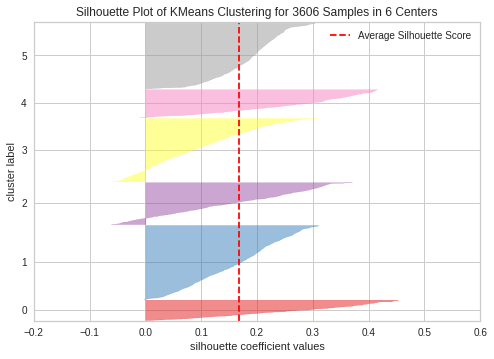

In [ ]:
test_vis = SilhouetteVisualizer(KMeans(n_clusters = kelbow_vis.elbow_value_, random_state=99)).fit(X)
y_cluster = test_vis.predict(X)
test_vis.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=17)
X_trans = pca.fit_transform(X)
evr = pca.explained_variance_ratio_

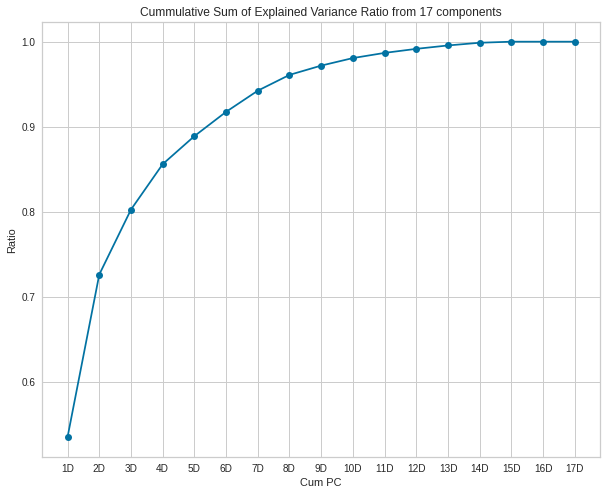

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot([str(i+1)+'D' for i in range(len(evr))], np.cumsum(evr), marker='o')
plt.title('Cummulative Sum of Explained Variance Ratio from 17 components')
plt.xlabel('Cum PC')
plt.ylabel('Ratio')
plt.show()

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

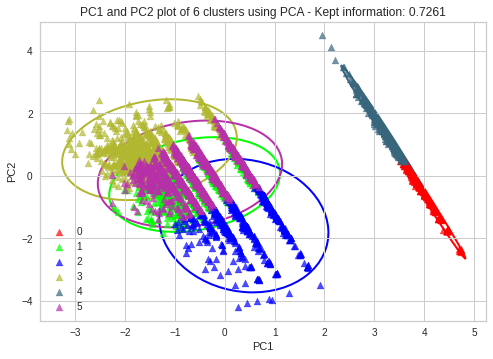

In [ ]:
figure = plt.figure()
axis = figure.add_subplot(111)
dot_colors = ['#FF0000', '#00FF00', '#0000FF', '#b1b830', '#38667d', '#b830aa']

for label in set(y_cluster):
  plt.scatter(X_trans[y_cluster == label, 0], X_trans[y_cluster == label, 1],c=dot_colors[label], marker='^', alpha=0.7, label=label)

for label in set(y_cluster):
  confidence_ellipse(X_trans[y_cluster == label, 0], X_trans[y_cluster == label, 1], axis, linewidth=2, edgecolor=dot_colors[label], zorder=0)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PC1 and PC2 plot of 6 clusters using PCA - Kept information: {evr[:2].sum():.4f}')
plt.show()

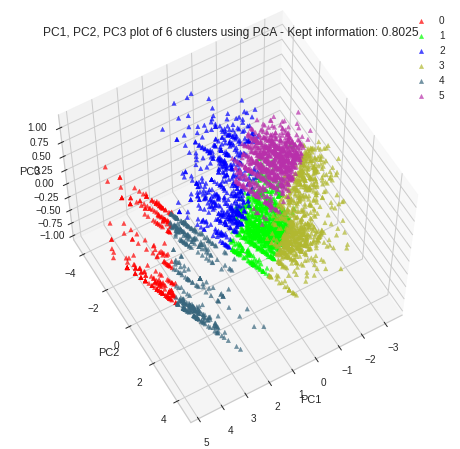

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

for label in set(y_cluster):
  ax.scatter(X_trans[y_cluster == label, 0], X_trans[y_cluster == label, 1], X_trans[y_cluster == label, 2],c=dot_colors[label], marker='^', alpha=0.7, label=label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(f'PC1, PC2, PC3 plot of 6 clusters using PCA - Kept information: {evr[:3].sum():.4f}')
ax.view_init(elev=60., azim=60)

plt.legend()
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=X_trans[:, 0],y=X_trans[:, 1],z=X_trans[:, 2], color=y_cluster)
fig.show()